In this notebook, we present various usecases for categorical values.

In [1]:
# Preamble to run notebook in context of source package.
import sys
sys.path.insert(0, '../')

In [2]:
from IPython.core.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcdefaults()
import numpy as np
import pandas as pd
# import pprint

from ptype.Column import Column2ARFF
from ptype.Ptype import Ptype
from ptype.utils import evaluate_types
from utils import *

I plan to discuss two use-cases: 
- misclassifying categorical values as anomalies due to unsupported characters (Eucalyptus Soil Conservation Dataset),
- merging categorical values when we have string variability issues (USP05 Dataset).


### Eucalyptus Soil Conservation Dataset

In [3]:
df = pd.read_csv('../data/eucalyptus.csv')
df.head()

,Abbrev,Rep,Locality,Latitude,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,Utility
0,Cra,1,Central_Hawkes_Bay,39__38,100,850,-2,1980,co,1520.0,18.45,9.96,40.0,4.0,3.0,3.5,4.0,3.5,good
1,Cra,1,Central_Hawkes_Bay,39__38,100,850,-2,1980,fr,1487.0,13.15,9.65,90.0,4.5,4.0,3.5,3.5,3.0,best
2,Cra,1,Central_Hawkes_Bay,39__38,100,850,-2,1980,ma,1362.0,10.32,6.50,50.0,2.3,2.5,3.0,3.5,3.0,low
3,Cra,1,Central_Hawkes_Bay,39__38,100,850,-2,1980,nd,1596.0,14.80,9.48,70.0,3.7,3.0,3.3,4.0,3.5,good
4,Cra,1,Central_Hawkes_Bay,39__38,100,850,-2,1980,ni,2088.0,14.50,10.78,90.0,4.0,2.7,3.3,3.0,3.0,good


### The Analytical Task

We use this dataset for an analytical task where we predict the "Utility" of given conditions.

### A Solution using Standard Python Libraries
Let's now develop a simple solution for this problem.

In [4]:
features = ['Sp', 'Locality', 'Altitude', 'Rainfall', 'Ht', 'Surv', 'Vig']
target = ['Utility']

X = df[features]
y = df[target]

df = df[features+target]
df.head()

,Sp,Locality,Altitude,Rainfall,Ht,Surv,Vig,Utility
0,co,Central_Hawkes_Bay,100,850,9.96,40.0,4.0,good
1,fr,Central_Hawkes_Bay,100,850,9.65,90.0,4.5,best
2,ma,Central_Hawkes_Bay,100,850,6.50,50.0,2.3,low
3,nd,Central_Hawkes_Bay,100,850,9.48,70.0,3.7,good
4,ni,Central_Hawkes_Bay,100,850,10.78,90.0,4.0,good


Both Sp and Locality are categorical columns. But Pandas cannot automatically label data columns with categorical types. Instead, they are classified as object.

In [5]:
df.dtypes

Sp           object
Locality     object
Altitude      int64
Rainfall      int64
Ht          float64
Surv        float64
Vig         float64
Utility      object
dtype: object

In [6]:
# to see the error message, uncomment the following

# clf = DecisionTreeClassifier(min_samples_leaf=3, max_leaf_nodes=5, max_depth=4)
                    
clf = LogisticRegression(multi_class="multinomial", max_iter=10000, penalty="l2")

# clf.fit(X, y)

We notice that we need to encode the categorical variables using one-hot encoding.

In [7]:
df = pd.get_dummies(df, columns=['Sp', 'Locality'])

features = [col for col in list(df.columns) if col not in target]

X = df[features]
y = df[target].values

df = df[features+target]
df.head()

,Altitude,Rainfall,Ht,Surv,Vig,Sp_ag,Sp_am,Sp_br,Sp_bxs,Sp_co,...,Sp_te,Locality_Central_Hawkes_Bay,Locality_Central_Hawkes_Bay_(coastal),Locality_Central_Poverty_Bay,Locality_Central_Wairarapa,Locality_Northern_Hawkes_Bay,Locality_South_Wairarapa,Locality_Southern_Hawkes_Bay,Locality_Southern_Hawkes_Bay_(coastal),Utility
0,100,850,9.96,40.0,4.0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,good
1,100,850,9.65,90.0,4.5,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,best
2,100,850,6.50,50.0,2.3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,low
3,100,850,9.48,70.0,3.7,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,good
4,100,850,10.78,90.0,4.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,good


In [8]:
clf = LogisticRegression(multi_class="multinomial", max_iter=10000, penalty="l2")
# clf = DecisionTreeClassifier(min_samples_leaf=3, max_leaf_nodes=40, max_depth=20)

# clf.fit(X, y)

In [9]:
df.isnull().sum()

Altitude                                   0
Rainfall                                   0
Ht                                         1
Surv                                      94
Vig                                       69
Sp_ag                                      0
Sp_am                                      0
Sp_br                                      0
Sp_bxs                                     0
Sp_co                                      0
Sp_cr                                      0
Sp_el                                      0
Sp_fa                                      0
Sp_fr                                      0
Sp_jo                                      0
Sp_ka                                      0
Sp_ma                                      0
Sp_mn                                      0
Sp_nc                                      0
Sp_nd                                      0
Sp_ni                                      0
Sp_ob                                      0
Sp_ov     

In [10]:
n = df.shape[0]
df.dropna(subset=["Ht", "Surv", "Vig"], axis=0, inplace=True)
print("# rows deleted = " + str(n-df.shape[0]))

# update the indices
df.reset_index(drop=True, inplace=True)

# rows deleted = 94


In [11]:
# NBVAL_IGNORE_OUTPUT
# (can‘t make the value nbval sees locally (0.67) agree with the server (0.68))

from sklearn.preprocessing import RobustScaler

X = df[features]
y = df[target].values

# normalize some features
scaler = RobustScaler()
features_to_normalize = ['Altitude', 'Rainfall', 'Ht', "Surv", 'Vig'] 
features_normalized = scaler.fit_transform(X[features_to_normalize])
I = features_normalized.shape[0]
for j, feature_to_normalize in enumerate(features_to_normalize):
    for i in range(I):        
        j_ = features.index(feature_to_normalize)
        X.loc[i,j_] = features_normalized[i,j]
        
clf = LogisticRegression(multi_class="multinomial", max_iter=20000, penalty="l2", random_state=0)
clf.fit(X, y.ravel())
y_hat = clf.predict(X)

print('Overall Accuracy:', round(metrics.accuracy_score(y, y_hat), 2))

Overall Accuracy: 0.67


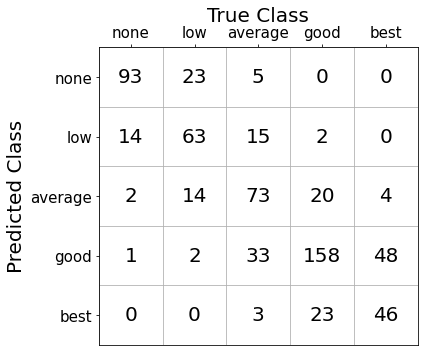

In [12]:
labels = ['none', 'low', 'average', 'good', 'best']
cm = confusion_matrix(y, y_hat, labels)

plot_confusion_matrix(cm, labels)
# note that none is not missing data (none<0.1, low<1.48, average<2.65, good<3.83, best<5.00)
# (see https://www.cs.waikato.ac.nz/ml/publications/1996/Thomson-McQueen-96.pdf)

Let's now reproduce the error and see how we can use ptype to resolve the issue.

In [13]:
df = pd.read_csv('../data/eucalyptus.csv', dtype='str', keep_default_na=False)

features = ['Sp', 'Locality', 'Altitude', 'Rainfall', 'Ht', 'Surv', 'Vig']
target = ['Utility']

X = df[features]
y = df[target]

df = df[features+target]
df.head()

,Sp,Locality,Altitude,Rainfall,Ht,Surv,Vig,Utility
0,co,Central_Hawkes_Bay,100,850,9.96,40,4,good
1,fr,Central_Hawkes_Bay,100,850,9.65,90,4.5,best
2,ma,Central_Hawkes_Bay,100,850,6.5,50,2.3,low
3,nd,Central_Hawkes_Bay,100,850,9.48,70,3.7,good
4,ni,Central_Hawkes_Bay,100,850,10.78,90,4,good


In [14]:
ptype = Ptype()

schema = ptype.fit_schema(df)
schema
# pprint.pprint(schema)

{'Sp': {'series': 0      co
 1      fr
 2      ma
 3      nd
 4      ni
        ..
 731    fa
 732    fr
 733    ni
 734    ob
 735    re
 Name: Sp, Length: 736, dtype: object, 'p_t': {'integer': 0.0, 'string': 1.0, 'float': 0.0, 'boolean': 0.0, 'date-iso-8601': 0.0, 'date-eu': 0.0, 'date-non-std-subtype': 0.0, 'date-non-std': 0.0}, 'p_t_canonical': {}, 'p_z': {'integer': array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]), 'string': array([[1.00000000e+

In [15]:
schema['Locality'].categorical_values

['Central_Hawkes_Bay',
 'Central_Poverty_Bay',
 'Central_Wairarapa',
 'Northern_Hawkes_Bay',
 'South_Wairarapa',
 'Southern_Hawkes_Bay']

In [16]:
print(schema['Locality'].get_missing_values())

print(schema['Locality'].get_anomalous_values())

[]
['Central_Hawkes_Bay_(coastal)', 'Southern_Hawkes_Bay_(coastal)']


In [17]:
ptype.show_schema()

,Sp,Locality,Altitude,Rainfall,Ht,Surv,Vig,Utility
type,string,string,integer,integer,float,float,float,string
normal values,"[ag, am, br, bxs, co, cr, el, fa, fr, jo, ka, ...","[Central_Hawkes_Bay, Central_Poverty_Bay, Cent...","[100, 130, 150, 160, 180, 200, 220, 300, 70]","[1000, 1050, 1080, 1200, 1250, 1300, 1400, 175...","[1.12, 1.53, 1.74, 1.75, 1.8, 1.89, 10, 10.02,...","[1.5, 10, 100, 13, 14, 17, 18, 2, 2.5, 20, 21,...","[0.5, 1, 1.3, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.3,...","[average, best, good, low, none]"
ratio of normal values,1,0.83,1,1,1,0.87,0.91,1
missing values,[],[],[],[],[],[],[],[]
ratio of missing values,0,0,0,0,0,0.13,0.09,0
anomalous values,[],"[Central_Hawkes_Bay_(coastal), Southern_Hawkes...",[],[],[],[],[],[]
ratio of anomalous values,0,0.17,0,0,0,0,0,0


In [18]:
df = ptype.transform_schema(df, schema)

In [19]:
df.head()

,Sp,Locality,Altitude,Rainfall,Ht,Surv,Vig,Utility
0,co,Central_Hawkes_Bay,100,850,9.96,40.0,4.0,good
1,fr,Central_Hawkes_Bay,100,850,9.65,90.0,4.5,best
2,ma,Central_Hawkes_Bay,100,850,6.50,50.0,2.3,low
3,nd,Central_Hawkes_Bay,100,850,9.48,70.0,3.7,good
4,ni,Central_Hawkes_Bay,100,850,10.78,90.0,4.0,good


In [20]:
df.dtypes

Sp           string
Locality     string
Altitude      Int64
Rainfall      Int64
Ht          float64
Surv        float64
Vig         float64
Utility      string
dtype: object

In [21]:
cat_columns = [column for column in schema if column != 'Utility' and schema[column].arff_type == 'nominal' ]
df = pd.get_dummies(df, columns=cat_columns)

features = [col for col in list(df.columns) if col not in target]

X = df[features]
y = df[target].values

df = df[features+target]
df.head()

,Ht,Surv,Vig,Sp_ag,Sp_am,Sp_br,Sp_bxs,Sp_co,Sp_cr,Sp_el,...,Rainfall_900,Rainfall_1000,Rainfall_1050,Rainfall_1080,Rainfall_1200,Rainfall_1250,Rainfall_1300,Rainfall_1400,Rainfall_1750,Utility
0,9.96,40.0,4.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,good
1,9.65,90.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,best
2,6.50,50.0,2.3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,low
3,9.48,70.0,3.7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,good
4,10.78,90.0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,good


In [22]:
clf = LogisticRegression(multi_class="multinomial", max_iter=10000, penalty="l2")
# clf.fit(X, y)

In [23]:
df.isnull().sum()

Ht                               1
Surv                            94
Vig                             69
Sp_ag                            0
Sp_am                            0
Sp_br                            0
Sp_bxs                           0
Sp_co                            0
Sp_cr                            0
Sp_el                            0
Sp_fa                            0
Sp_fr                            0
Sp_jo                            0
Sp_ka                            0
Sp_ma                            0
Sp_mn                            0
Sp_nc                            0
Sp_nd                            0
Sp_ni                            0
Sp_ob                            0
Sp_ov                            0
Sp_pa                            0
Sp_pu                            0
Sp_ra                            0
Sp_rd                            0
Sp_re                            0
Sp_ro                            0
Sp_si                            0
Sp_sm               

In [24]:
n = df.shape[0]
df.dropna(subset=["Ht", "Surv", "Vig"], axis=0, inplace=True)
print("# rows deleted = " + str(n-df.shape[0]))

# update the indices
df.reset_index(drop=True, inplace=True)

# rows deleted = 94


In [25]:
# NBVAL_IGNORE_OUTPUT
# (can‘t make the value nbval sees locally (0.68) agree with the server (0.69))
X = df[features]
y = df[target].values

clf = LogisticRegression(multi_class="multinomial", max_iter=20000, penalty="l2", random_state=0)
clf.fit(X, y.ravel())
y_hat = clf.predict(X)

print('Overall Accuracy:', round(metrics.accuracy_score(y, y_hat), 2))

Overall Accuracy: 0.69


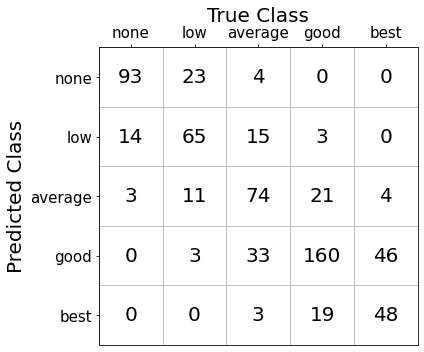

In [26]:
labels = ['none', 'low', 'average', 'good', 'best']
cm = confusion_matrix(y, y_hat, labels)

plot_confusion_matrix(cm, labels)
# note that none is not missing data (none<0.1, low<1.48, average<2.65, good<3.83, best<5.00)
# (see https://www.cs.waikato.ac.nz/ml/publications/1996/Thomson-McQueen-96.pdf)

### USP05 Dataset

In [27]:
# NBVAL_IGNORE_OUTPUT
# couldn't agree - may be due to clevercsv
import clevercsv

# pandas read_csv couldn't properly parse the file
df = clevercsv.csv2df("../data/usp05.csv")
df.head()

,"""ID""","""ObjType""","""Effort""","""FunctPercent""","""IntComplx""","""DataFile""","""DataEn""","""DataOut""","""UFP""","""Lang""","""Tools""","""ToolExpr""","""AppExpr""","""TeamSize""","""DBMS""","""Method""","""AppType"""
0,101,FT,2.5,"0.00,0.80,0.10,0.10,0.00,0.00,0.00",5.0,18.0,94.0,NaN,NaN,sql,mySQLweb,"[2,60]",4.0,[1],mysql,NaN,BC/S
1,102,FT,2.5,"0.00,0.70,0.00,0.10,0.10,0.10,0.00",5.0,9.0,240.0,NaN,NaN,sql,mySQLweb,"[2,60]",4.0,[1],mysql,NaN,BC/S
2,114,FT,2.0,"0.10,0.30,0.10,0.30,0.00,0.00,0.20",2.0,9.0,15.0,0.0,0.0,"html,_php,_sql,_proprietary","notepad,_webforms","[2,_60]",4.0,[1],mysql,"SA,SD",BC/S
3,115,FT,2.0,"0.10,0.30,0.10,0.30,0.00,0.00,0.20",2.0,9.0,15.0,0.0,0.0,"html,_php,_sql,_proprietary","notepad,_webforms","[2,_60]",4.0,[1],mysql,"SA,SD",BC/S
4,116,FT,3.5,"0.10,0.30,0.10,0.30,0.00,0.00,0.20",2.0,9.0,15.0,0.0,0.0,"html,_php,_sql,_proprietary","notepad,_webforms","[2,_60]",5.0,[1],mysql,"SA,SD",BC/S
